# Crop production risk based on ISIMIP and FAO data


## Summary

This tutorial gives an overview of the modules in CLIMADA used to compute climate related risks to crop production on a 0.5° grid. The risk calculation is based on yearly crop yield as simulated by global gridded crop models (GGCMs) that are forced with climate variables such as temperature and water availability provided from climate model output or re-analysis data.

The hazard *relative_cropyield* is not a typical natural hazard but rather an aggregation of climatic impacts on the crop yield at each location. *relative_cropyield* intensi is equal to the change in crop_yield in a given year from the long-term averageIt is based on the crop yield simulated by GGCMs. In the CLIMADA framework, we are setting relative_cropyield as “hazard” because it describes the year-by-year climatic influence on agriculture, each year representing one event. This hazard can be applied on any exposure that represents a (mean) amount of crop produced at any location.

Here, we use the exposure *crop_production* (in tonnes or USD per year) that distributes national crop production as extracted from FAO statistics proportional to a gridded distribution of crop production that is based on mean crop yield in tonnes per hectare multiplied with the hectares of harvest area per grid cell.

### Example calculation:

At a certain grid cell, the area fraction for non-irrigated rice is 5% and the area of the grid cell is 250,000 ha with an average historical crop yield of 6 tonnes per ha and year.

The exposure (*crop_production*) value is the product of area fraction, area, and average yield = $0.05 * 250,000 ha * 6 t/(ha*y) = 75,000 t/y$.

The hazard intensity at this grid cell for non-irrigated rice in a certain year is -20% (*relative_cropyield*), caused by climate variables such as temperature and water availability during that year.

For this specific year, the impact as computed with Impact.calc is the product of hazard and exposure: $75,000 t/y * (-0.20) * 1 y = -15,000 t$.

## Data sources

The two classes *RelativeCropyield(Hazard)* and *CropProduction(Exposure)* can be combined to calculate climate impacts on crop production based on simulations data from global gridded crop models (GGCMs) within the Inter-Sectoral Impact Model Intercomparison Project (ISIMIP, https://www.isimip.org/) as well as statistics from the Food and Agriculture Organization of the United Nations (FAO, http://www.fao.org/faostat/en/#home).


From the ISIMIP project, a variety of model runs with yearly crop yield data on a spatial resolution of 0.5° x 0.5° are available. Each run is based on one GGCM forced by a climate model output or re-analysis data. Runs are available for different crop types, model combinations, historical climate and future climate scenarios, and other model parameters. The hazard is generated by the class *RelativeCropyield(Hazard)* that extracts crop yield data simulated by GGCMs. The GGCM runs provided by ISIMIP are forced with the output from climate models (e.g. in ISIMIP2b, ISIMIP3b) or re-analyis data (ISIMIP2a, ISIMIP3a). The driving climate variables for crop yield are temperature, water availability, CO2 concentrations, and nitrogen availability. Additionally, land use data required for *CropProduction(Exposure)* is available from the ISIMIP input data (e.g. histsoc_landuse-15crops_annual_1861_2005.nc for ISIMIP2).


The required ISIMIP data sets are available from https://esg.pik-potsdam.de/search/isimip/ (choose *Variable = yield* for crop yield and *landuse-15crops* for land use data).


In this tutorial we show how a *RelativeCropyield* and a *CropProduction* instance can be initiated and translated into socio-economic impacts in the form of (yearly) crop production losses / gains in tonnes or USD.

## RelativeCropyield Hazard

Hazard intensity in the class *RelativeCropyield* is defined as yearly crop yield relative to a historical mean simulated with the same model combination. Each model year represents one event in the hazard instance.

The method *set_from_isimip_netcdf()* generates a *Hazard* instance from one model run, with intensity 'Yearly Yield'.
This requires multiple input parameters to specify the model run:

            input_dir (string): path to input data directory
            bbox (list of four floats): bounding box:
                [lon min, lat min, lon max, lat max],
            yearrange (int tuple): year range for hazard set, f.i. (1976, 2005)
            ag_model (str): abbrev. agricultural model (only when input_dir is selected)
                f.i. 'gepic' etc.
            cl_model (str): abbrev. climate model (only when input_dir is selected)
                f.i. 'gfdl-esm2m' etc.
            scenario (str): climate change scenario (only when input_dir is selected)
                f.i. 'historical' or 'rcp60'
            soc (str): socio-economic trajectory (only when input_dir is selected)
                f.i. '2005soc' or 'histsoc'
            co2 (str): CO2 forcing scenario (only when input_dir is selected)
                f.i. 'co2' or '2005co2'
            crop (str): crop type, e.g. 'whe', 'mai', 'soy' or 'ric'
            irr (str): irrigation type, e.g. 'noirr' or 'irr'

In addition to the general attributes of the *Hazard()* class, the class *RelativeCropyield()* has further attributes related to the crop type and intensity definition:
           
            crop (str): crop type, e.g. 'whe', 'mai', 'soy', or 'ric';
            intensity_def (str): intensity unit definition, either 
                'Relative Yield' (unitless), 'Yearly Yield' [t/(y*ha)], or 'Percentile' [t/(y*ha)]

To convert intensity to 'Relative Yield', the methods *calc_mean()* and *set_rel_yield_to_int()* can be applied as shown below. Attention: This is required for impact calculations in combination with *CropProduction(Exposure)*.

To initiate one or more hazard files from a variety of model runs, a more convenient function is available:
*climada.hazard.relative_cropyield.set_multiple_rc_from_isimip()*, setting intensity to 'Relative Yield' for you.
The function *set_multiple_rc_from_isimip()* extracts all model specifications directly from the filenames. Thus, it only requires the following inputs:

            input_dir (str): path to input data directory
            output_dir (str): path to output data directory (hazard sets are saved there in HDF5-format)
            return_data (boolean): set to True if you want the function to return a list containing the haz. sets 
            

Below two examples for initiating an hazard instance and setting intensity to relative yield:

###  Initiate a single hazard instance and set intensity to relative yield manually (demo data sample):
- using *set_from_isimip_netcdf()*
- using demo data (cropped to France and Germany, 2001-2005)


Before calling set_rel_yield_to_int(), intensity is 'Yearly Yield' with unit 't / y / ha'.

After calling set_rel_yield_to_int(), intensity is 'Relative Yield' with unit ''.



'The map shows relative crop yield in the model year 2003. Positive (negative) values correspond to a relative yield surplus (deficit)'

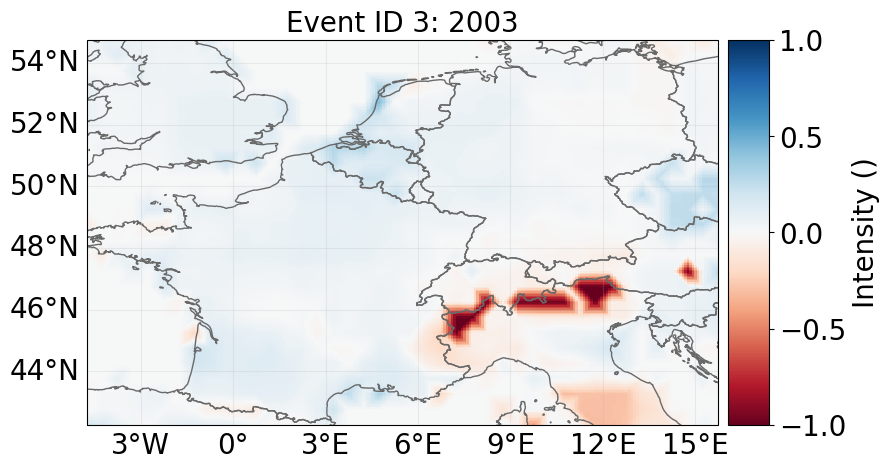

In [3]:
import os
from climada_petals.hazard.relative_cropyield import RelativeCropyield
from climada.util.constants import DEMO_DIR as INPUT_DIR

FN_STR_DEMO = 'annual_FR_DE_DEMO'

yearrange_haz = (2001, 2005) # yearrange for hazard (demo data only available from 2001 to 2005)
yearrange_hist_mean = (2001, 2005) # yearrange for reference historical mean (demo data only available from 2001 to 2005)
haz = RelativeCropyield()
haz.set_from_isimip_netcdf(input_dir=INPUT_DIR, yearrange=yearrange_haz, ag_model='lpjml',
                        cl_model='ipsl-cm5a-lr', scenario='historical', soc='2005soc',
                        co2='co2', crop='whe', irr='noirr', fn_str_var=FN_STR_DEMO)

print("\nBefore calling set_rel_yield_to_int(), intensity is '%s' with unit '%s'.\n" %(haz.intensity_def, haz.units))

hist_mean = haz.calc_mean(yearrange_hist_mean) # requires reference year range as input
"""compute historical mean yield per grid cell for reference (base line)"""
haz.set_rel_yield_to_int(hist_mean)
"""set intensity to relative yield by dividing yield/hist_mean"""

print("After calling set_rel_yield_to_int(), intensity is '%s' with unit '%s'.\n" %(haz.intensity_def, haz.units))

haz.plot_intensity_cp(event=3)
"""The map shows relative crop yield in the model year 2003. Positive (negative) values correspond to a relative yield surplus (deficit)"""
# please note that the run used here is not based on historical re-analysis data but on simulated climate,
# i.e. the climate variables of year "2003" do not correspond to the actual year 2003.
# (only the forcing of the climate models is historical) 

###  Initiate a relative yield hazard set from multiple input files:

- using *set_multiple_rc_from_isimip()*, which creates hazard sets from all NetCDF-files found in the input directory
- in this example, I used the output from GGCM GEPIC forced with GFDL-ESM2M output for rice, both irrigated and non-irrigated. You can however also run the script with other data sets of the same format.

Requires data download from https://esg.pik-potsdam.de/search/isimip/:
- gepic_gfdl-esm2m_ewembi_historical_2005soc_co2_yield-ric-firr_global_annual_1861_2005.nc
- gepic_gfdl-esm2m_ewembi_historical_2005soc_co2_yield-ric-noirr_global_annual_1861_2005.nc
- gepic_gfdl-esm2m_ewembi_rcp60_2005soc_co2_yield-ric-firr_global_annual_2006_2099.nc
- gepic_gfdl-esm2m_ewembi_rcp60_2005soc_co2_yield-ric-noirr_global_annual_2006_2099.nc

These files contain historical and RCP6.0 future simulations for _rice_ yield, both for fully irrigated ("firr") and no irrigation ("noirr"). Forcing climate model: _gfdl-esm2m_. Crop model: _gepic_.

Please note: when calling *init_full_hazard_set()*. the historical mean (hist_mean) is averaged over all model combinations for each crop and irrigation type. Like this, a cross-model exposure can be initiated using this model average of hist_mean as input.

In [5]:
from climada import CONFIG
from climada_petals.hazard.relative_cropyield import set_multiple_rc_from_isimip


data_path = CONFIG.local_data.save_dir.dir() / "ISIMIP_crop" # set path of working data directory 
input_haz_dir = data_path / "Input" / "Hazard_tutorial" # set path where you place hazard input data
input_haz_dir.mkdir(parents=True, exist_ok=True)
# (Place crop yield data (.nc) from ISIMIP in input_haz_dir)

output_dir = data_path / "Output" # set output directory
path_hist_mean = output_dir / "Hist_mean" # set output directory for hist_mean
path_hist_mean.mkdir(parents=True, exist_ok=True)

filelist_haz, hazards_list = set_multiple_rc_from_isimip(input_dir=input_haz_dir, output_dir=output_dir,
                                                      isimip_run='ISIMIP2b', return_data=True)

print("\nComputed and saved the following files: \n")
print(filelist_haz)

print("\nIntensity of the hazard sets is '%s' with unit '%s'.\n" %(hazards_list[0].intensity_def, hazards_list[0].units))

hazards_list[1].plot_intensity_cp(event=1);

IndexError: list index out of range

## CropProduction Exposure


The *CropProduction* exposure data represents the mean crop production per grid cell.
For creating an exposure instance, the following main input data are combined:
- harvest area fraction (from landuse data): fraction of grid cell area where a crop is grown with / without irrigation, unitless;
- total grid cell area [$ha$]: computed from grid;
- historical mean yield (hist_mean): simulated crop yield with / without irrigation per grid cell, usually averaged over several model combinations and years, can be initiated with function *set_multiple_rc_from_isimip* [$t / (ha * y)$];
- crop production price from FAO when unit is USD $[USD / t]$.

Crop production = fraction * area * hist_mean * price

$[USD / y = ha * t / (ha * y) * USD / t]$

Unit definitions:

- $USD$: US dollars
- $y$: year
- $ha$: hectar, $1 ha =  10000 m^2$
- $t$: tonnnes, $1 t = 1000 kg$

The method *set_from_isimip_netcdf()* generates a *Exposure* instance for one crop type and irrigation parameter, with unit 't/year' or 'USD/year'.
This requires multiple input parameters:

            input_dir (string): path to input data directory
            filename (string): name of the landuse-file to use,
                e.g. "histsoc_landuse-15crops_annual_1861_2005.nc"
            hist_mean (array): historic mean crop yield per centroid (from hazard)
            bbox (list of four floats): bounding box:
                [lon min, lat min, lon max, lat max]
            yearrange (int tuple): year range for exposure set
                f.i. (1990, 2010)
            scenario (string): climate change and socio economic scenario
                f.i. 'histsoc' or 'rcp60soc'
            cl_model (string): abbrev. climate model (only when landuse data
            is future projection)
                f.i. 'gfdl-esm2m' etc.
            crop (string): crop type
                f.i. 'mai', 'ric', 'whe', 'soy'
            irr (string): irrigation type
                f.i 'firr' (full irrigation), 'noirr' (no irrigation) or 'combined'= firr+noirr
            unit (string): unit of the exposure (per year)
                f.i 'USD/y' or 't/y'
            fn_str_var (string): FileName STRing depending on VARiable and
                ISIMIP simuation round


In addition to the general attributes of the *Exposures()* class, the class *CropProduction()* has one further attribute related:
           
            crop (str): crop type, e.g. 'whe', 'mai', 'soy', or 'ric'


Below two examples for initiating an Exposures instance:

###  Initiating a single exposure instance (demo data sample):

c:\users\me\git\climada_python\climada\util\coordinates.py:2747: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(


<GeoAxes: >

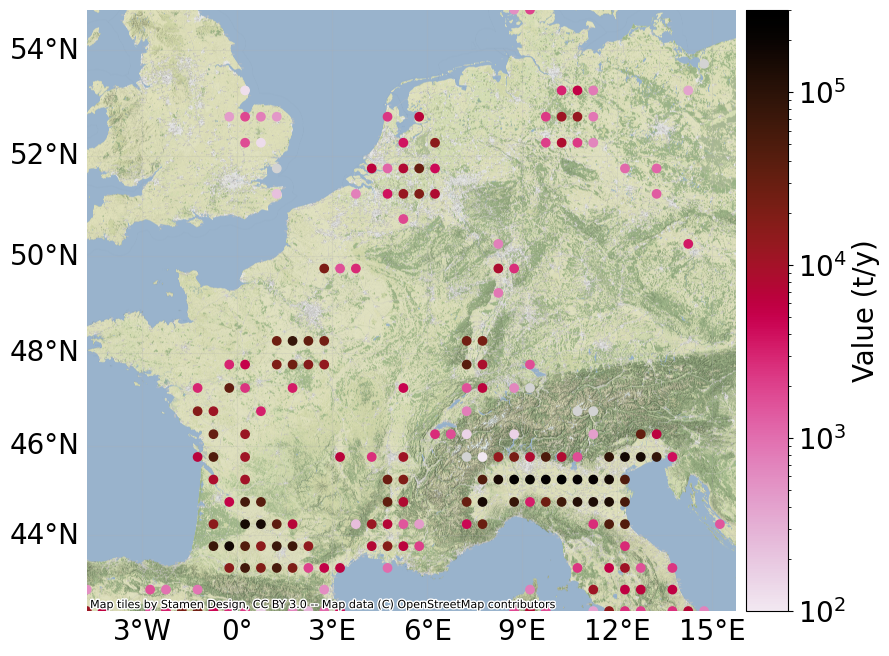

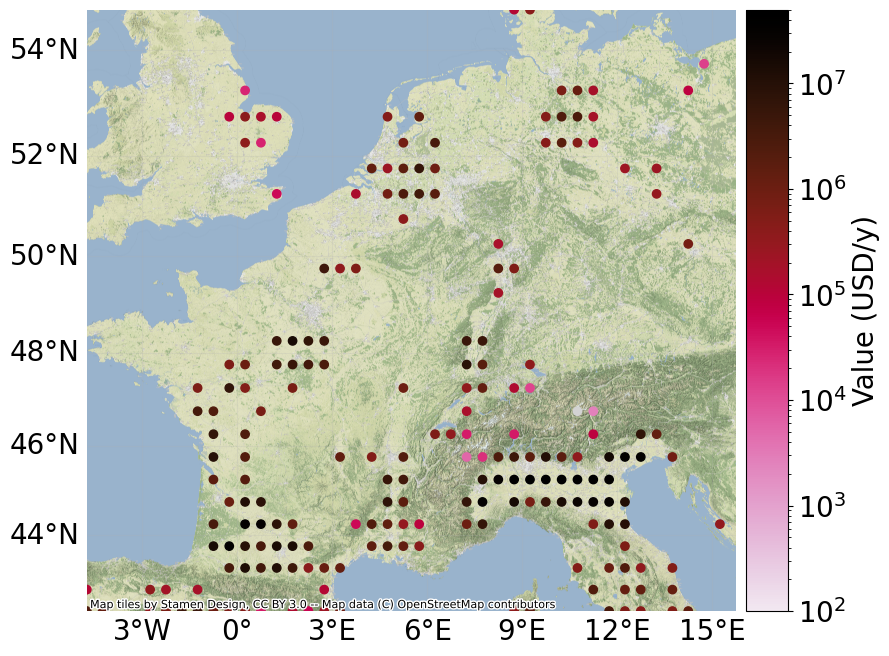

In [6]:
from matplotlib import colors

from climada_petals.entity.exposures.crop_production import CropProduction
from climada.util.constants import DEMO_DIR as INPUT_DIR

FILENAME = 'histsoc_landuse-15crops_annual_FR_DE_DEMO_2001_2005.nc'
FILENAME_MEAN = 'hist_mean_mai-firr_1976-2005_DE_FR.hdf5'

exp = CropProduction()
exp.set_from_isimip_netcdf(input_dir=INPUT_DIR, filename=FILENAME, hist_mean=FILENAME_MEAN,
                                      bbox=[-5, 42, 16, 55], yearrange=(2001, 2005), crop='mai',
                                      scenario='flexible', unit='t/y', irr='firr')
"""compute maize crop production..."""
norm=colors.LogNorm(vmin=1e2, vmax=3e5)
exp.plot_basemap(norm=norm, pop_name=False) # warning: slow to plot basemap
# exp.plot_scatter(norm=norm, s=50) # faster

exp.set_value_to_usd(INPUT_DIR)
"""compute USD value (with prices from FAO)..."""
norm=colors.LogNorm(vmin=1e2, vmax=5e7)
exp.plot_basemap(norm=norm, pop_name=False) # warning: slow to plot basemap
# exp.plot_scatter(norm=norm, s=50) # faster

###  Initiating an exposure set from several model runs:
Requires data download from https://esg.pik-potsdam.de/search/isimip/:
- gepic_gfdl-esm2m_ewembi_historical_2005soc_co2_yield-ric-firr_global_annual_1861_2005.nc
- gepic_gfdl-esm2m_ewembi_historical_2005soc_co2_yield-ric-noirr_global_annual_1861_2005.nc
- histsoc_landuse-15crops_annual_1861_2005.nc

Requires data download from http://www.fao.org/faostat/en/#data/QC:
- Countries: all; Items: "Rice, paddy"; Elements: "Production Quantity", Years: 2008 to 2018.
- save as FAOSTAT_data_production_quantity.csv in your local input data directory (*input_exp_dir*)

Please note: when calling *set_multiple_rc_from_isimip()*. the historical mean (hist_mean) required here is averaged over all model combinations for each crop and irrigation type. This means that the exposure per crop type and irrigation type represents an average over all model ciombinations used.

#### Normalization:
It is possible to normalize the crop production per country with FAO data using *normalize_with_fao_cp()* and *normalize_several_exp()* for multiple exposure pairs.
The normalization follows three steps:
1. Total crop production per crop type (full irrigation + no irrigation) is summed for each country (model crop production).
2. An average crop production per crop type and country is extracted from FAO statistics (reported crop production).
3. Crop production is normalized by multiplying the values of each grid cell with the ratio of reported over model crop production.

As a result of normalization, crop production summed over a country and both irrigation types is equal to the avaerage reported crop production.


In [ ]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from climada.util.constants import CONFIG
import climada.util.coordinates as u_coord
from climada_petals.hazard.relative_cropyield import set_multiple_rc_from_isimip
from climada_petals.entity.exposures.crop_production import init_full_exp_set_isimip, normalize_several_exp

data_path = CONFIG.local_data.save_dir.dir() / 'ISIMIP_crop' # set path of working data directory 
input_haz_dir = data_path / "Input" / "Hazard_tutorial" # set path where you place hazard input data
# (Place crop yield data (.nc) from ISIMIP in input_haz_dir)
input_exp_dir = data_path / "Input" / "Exposure" # save FAO data and histsoc_landuse-15crops_annual_1861_2005.nc here.

output_dir = data_path / "Output_tutorial" # set output directory
path_hist_mean = output_dir / 'Hist_mean' # set output directory for hist_mean

# # only required if hazard set has not yet been initiated above:
#---------------------------------------------------------------
# set_multiple_rc_from_isimip(input_dir=input_haz_dir, output_dir=output_dir)
# """compute historical mean yield for all runs available in input_haz directory"""
#---------------------------------------------------------------

filelist_exp, exposures = init_full_exp_set_isimip(input_dir=input_exp_dir, hist_mean_dir=path_hist_mean, \
                                                 output_dir=output_dir, return_data=True)
"""create exposures for all hist_mean files available in path_hist_mean directory"""
print("\nExposure files created:\n")
print(filelist_exp)

norm=colors.LogNorm(vmin=1e2, vmax=3e5)
exposures[0].plot_scatter(norm=norm, s=20, pop_name=False)
exposures[1].plot_scatter(norm=norm, s=20, pop_name=False)
"""For each crop type, an exposure with full irrigation crop production and one with no irrigation is created."""

crop_list, countries_list, ratio_list, exp_firr_norm, exp_noirr_norm, fao_cp_list, exp_tot_cp_list = \
    normalize_several_exp(input_dir=input_exp_dir, output_dir=output_dir,
                          yearrange=(2008, 2018),
                          unit='t/y', returns='all')
"""normalize crop production per country using FAO data"""

exp_noirr_norm[0].plot_scatter(norm=norm, s=20, pop_name=False)
exp_firr_norm[0].plot_scatter(norm=norm, s=20, pop_name=False)

fig_scatter = plt.figure(facecolor='w', figsize=(7, 7))
ax_s = fig_scatter.add_subplot(1,1,1)
ax_s.scatter(exp_tot_cp_list, fao_cp_list)
ax_s.plot([0,2e8], [0,2e8], alpha=.5)
index_max_fao = np.where(fao_cp_list[0]==np.nanmax(fao_cp_list[0]))[0][0]
index_max_isimip = np.where(exp_tot_cp_list[0]==np.nanmax(exp_tot_cp_list[0]))[0][0]
# print(ratio_list[0])

ax_s.text(exp_tot_cp_list[0][index_max_fao], fao_cp_list[0][index_max_fao],
          u_coord.country_to_iso(countries_list[0][index_max_fao], 'name'))
ax_s.text(exp_tot_cp_list[0][index_max_isimip], fao_cp_list[0][index_max_isimip],
          u_coord.country_to_iso(countries_list[0][index_max_isimip], 'name'))
ax_s.set_title('Rice: total crop production (CP) per country')
ax_s.set_xlabel('CP before normalization [t/y]')
ax_s.set_ylabel('FAO statistics (used for normalization) [t/y]')



FileNotFoundError: [WinError 3] The system cannot find the path specified: 'c:\\Users\\me\\git\\climada_petals\\doc\\tutorial\\results\\ISIMIP_crop\\Output_tutorial\\Hist_mean'

## Impact: Deviation in yearly crop production 


### Computing impact from single file (end-to-end; demo data):

Relative crop yield and historical crop production is combined to calculate the deviation of crop production from the historical mean production.

The impact function (*ImpfRelativeCropyield*) corresponds to a simple multiplication of hazard intensity (relative yield) with exposure (baseline production). As a result, the impact represents the deviation of yearly production from the exposure value.

There are positive and negative impact values. Positive values represent a crop production surplus. Negative values represent a deficit.

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from climada_petals.entity.exposures.crop_production import CropProduction
from climada_petals.hazard.relative_cropyield import RelativeCropyield
from climada.util.constants import DEMO_DIR as INPUT_DIR
from climada.entity import ImpactFuncSet, ImpfRelativeCropyield
from climada.engine import Impact

FN_STR_DEMO = 'annual_FR_DE_DEMO'
FILENAME_LU = 'histsoc_landuse-15crops_annual_FR_DE_DEMO_2001_2005.nc'
FILENAME_MEAN = 'hist_mean_mai-firr_1976-2005_DE_FR.hdf5'

yearrange_haz = (2001, 2005) # yearrange for hazard (demo data only available from 2001 to 2005)
yearrange_hist_mean = (2001, 2005) # yearrange for reference historical mean (demo data only available from 2001 to 2005)
haz = RelativeCropyield()
haz.set_from_isimip_netcdf(input_dir=INPUT_DIR, yearrange=yearrange_haz, ag_model='lpjml',
                        cl_model='ipsl-cm5a-lr', scenario='historical', soc='2005soc',
                        co2='co2', crop='whe', irr='noirr', fn_str_var=FN_STR_DEMO)
hist_mean = haz.calc_mean(yearrange_hist_mean) # requires reference year range as input
"""compute historical mean yield per grid cell for reference (base line)"""
haz.set_rel_yield_to_int(hist_mean)

exp = CropProduction()
exp.set_from_isimip_netcdf(input_dir=INPUT_DIR, filename=FILENAME_LU, hist_mean=FILENAME_MEAN,
                                      bbox=[-5, 42, 16, 55], yearrange=(2001, 2005),
                                      scenario='flexible', unit='t/y', irr='firr')
exp.set_value_to_usd(INPUT_DIR) # convert exposure from t/y to USD/y using FAO statistics
exp.assign_centroids(haz, threshold=20) # assign exposure points to centroids
"""Init hazard and exposure"""

impf_cp = ImpactFuncSet()
impf_def = ImpfRelativeCropyield()
impf_def.set_relativeyield()
impf_cp.append(impf_def)
impf_cp.check()
impf_def.plot()
"""Import impact function"""

impact_demo= Impact()
impact_demo.calc(exp, impf_cp, haz)  
"""Calculate impact"""

fig_imp_demo = plt.figure(facecolor='w')
ax_imp_demo = fig_imp_demo.add_subplot(1,1,1)
ax_imp_demo.plot(impact_demo.event_id, impact_demo.at_event, 'g', lw=3)
ax_imp_demo.hlines(0, xmin=1, xmax=5, alpha=.85, ls=':')
ax_imp_demo.set_xticks(impact_demo.event_id)
ax_imp_demo.set_xticklabels(impact_demo.event_name)
ax_imp_demo.set_title('Impact: Maize production deviation (demo data)')
ax_imp_demo.set_xlabel('model year')
ax_imp_demo.set_ylabel('$\Delta$ Crop Production [%s]' %(exp.value_unit))
